In [1]:
import numpy as np
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from adjustText import adjust_text
import shap

import sys, os
sys.dont_write_bytecode = True
import conditions, analysis

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

PATH = 'Output_Figures'
os.makedirs(PATH, exist_ok=True)

PATH2 = 'Output_CSV'
os.makedirs(PATH2, exist_ok=True)

In [2]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']
target_name = condition['target_name']

converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
data, feat, target = converted['data'], converted['feat'], converted['target']

desc = converted['desc']
use_desc = desc.loc[:, feat.columns]
use_desc.to_csv(f'{PATH2}/use_desc_rwgs.csv')

add_desc = converted['add_desc']
add_aw = converted['add_aw']
feat_cols = feat.columns

data_cols = conditions.data_columns(Reaction, condition)
elem_cols = data_cols['elem']
wt_cols = data_cols['wt']
data[wt_cols] = data[wt_cols].astype('float')

data = data.drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1', 'Iteration', 'Catal prep', 'Reaction', 'Note'], axis=1)

data_sort = pd.DataFrame(index=np.arange(0, len(data), 1), columns=np.arange(0, len(data.columns), 1))
for i in range(len(data)):
    data_sort_elem = data.loc[i][[data.loc[i][wt_cols].sort_values(ascending=False).index[Adi].replace('_wt%', '') for Adi in range(add_num)]].reset_index().T.drop('index', axis=0)
    data_sort_wt = data.loc[i][wt_cols].sort_values(ascending=False).reset_index().T.drop('index', axis=0)
    data_sort.iloc[i] = pd.concat([data_sort_elem, data_sort_wt], axis=1)
data_sort = data_sort.rename(columns={
    0: f'{elem_cols[0]}', 1: f'{elem_cols[1]}', 2: f'{elem_cols[2]}', 3: f'{elem_cols[3]}', 4: f'{elem_cols[4]}',
    5: f'{wt_cols[0]}', 6: f'{wt_cols[1]}', 7: f'{wt_cols[2]}', 8: f'{wt_cols[3]}', 9: f'{wt_cols[4]}'
    }).reindex(columns=data.columns)
data_sort['Catalyst'] = 'Pt(3)/'

for i in range(len(data)):
    for j in range(add_num):
        if data_sort[elem_cols[j]][i] != 'H' and j == 0:
            data_sort['Catalyst'][i] += data_sort[elem_cols[j]][i]
        elif data_sort[elem_cols[j]][i] != 'H' and j != 0:
            data_sort['Catalyst'][i] += '-' + data_sort[elem_cols[j]][i]
        else:
            pass
        if data_sort[wt_cols[j]][i] >= 1:
            data_sort[wt_cols[j]][i] = data_sort[wt_cols[j]][i].astype(int)
            data_sort['Catalyst'][i] += '(' + data_sort[wt_cols[j]][i].astype(str) + ')'
        elif data_sort[wt_cols[j]][i] < 1 and data_sort[wt_cols[j]][i] > 0:
            data_sort['Catalyst'][i] += '(' + data_sort[wt_cols[j]][i].astype(str) + ')'
        else:
            pass
data_sort['Catalyst'] += '/TiO2'

Table_S4 = converted['data']
Table_S4 = Table_S4.drop(elem_cols, axis=1).drop(wt_cols, axis=1).drop(['Catal prep', 'Reaction', 'Note'], axis=1).rename(columns = {'No.':'ID'})
Table_S4.loc[:, ['CO Yield_%', 'CO formation rate_mmol min-1 gcat-1']] = Table_S4.loc[:, ['CO Yield_%', 'CO formation rate_mmol min-1 gcat-1']].round(2)
Table_S4.insert(loc = 1, column= 'Catalyst', value= data_sort['Catalyst'])
Table_S4.insert(loc = 3, column= 'CO selectivity_%', value= 100)
Table_S4.to_csv(f'{PATH2}/Table_S4.csv')
Table_S4.to_excel(f'{PATH2}/Table_S4.xlsx')

data_wt = converted['data']
data_wt = data_wt.drop(['CO Yield_%', 'Catal prep', 'Reaction', 'Note'], axis=1)
data_wt['Sum_wt%'] = data_wt.loc[:, ['Ad1_wt%', 'Ad2_wt%', 'Ad3_wt%', 'Ad4_wt%', 'Ad5_wt%']].sum(axis=1)

data_mol = converted['data']
for i in range(add_num):
    for j in range(len(data)):
        data_mol[f'Ad{i+1}_wt%'][j] =  (100*data_mol[f'Ad{i+1}_wt%'][j])/add_aw[data_mol[f'Ad{i+1}'][j]] # μmol (Cat. ammount: 10 mg)

data_mol = data_mol.rename(columns={'Ad1_wt%': 'Ad1_μmol', 'Ad2_wt%': 'Ad2_μmol', 'Ad3_wt%': 'Ad3_μmol', 'Ad4_wt%': 'Ad4_μmol', 'Ad5_wt%': 'Ad5_μmol'})
data_mol = data_mol.drop(['CO Yield_%', 'Catal prep', 'Reaction','Note'], axis=1)
data_mol['Highest_elem'] = data_mol.loc[:, ['Ad1_μmol', 'Ad2_μmol', 'Ad3_μmol', 'Ad4_μmol', 'Ad5_μmol']].idxmax(axis=1).str.strip('_μmol')
data_mol['Highest_μmol'] = data_mol.loc[:, ['Ad1_μmol', 'Ad2_μmol', 'Ad3_μmol', 'Ad4_μmol', 'Ad5_μmol']].max(axis=1)
for i in range(len(data_mol)):
    data_mol['Highest_elem'][i] = data_mol[data_mol['Highest_elem'][i]][i]


data_count = pd.DataFrame(index=np.arange(len(data_mol)), columns=add_desc.index)
for i in range(len(data_mol)):
    for j in range(add_num):
        data_count.loc[i, data_mol.loc[i, f'Ad{j+1}']] = 1 #data_mol.loc[i, f'Ad{j+1}_μmol']
data_count = data_count.fillna(0)
data_count = data_count.drop('H', axis=1)
data_count = pd.concat([data_count, data_mol[target_name]], axis=1)
data_count['Activity_level'] = 0

for i in range(len(data_count)):
    if data_count[target_name][i] > 0 and data_count[target_name][i] <= 0.5:
        data_count['Activity_level'][i] = 0
    elif data_count[target_name][i] > 0.5 and data_count[target_name][i] <= 1.0:
        data_count['Activity_level'][i] = 1
    elif data_count[target_name][i] > 1.0 and data_count[target_name][i] <= 1.5:
        data_count['Activity_level'][i] = 2
    elif data_count[target_name][i] > 1.5 and data_count[target_name][i] <= 2.0:
        data_count['Activity_level'][i] = 3
    elif data_count[target_name][i] > 2.0 and data_count[target_name][i] <= 2.5:
        data_count['Activity_level'][i] = 4
    elif data_count[target_name][i] > 2.5 and data_count[target_name][i] <= 3.0:
        data_count['Activity_level'][i] = 5
    elif data_count[target_name][i] > 3.0 and data_count[target_name][i] <= 3.5:
        data_count['Activity_level'][i] = 6
    elif data_count[target_name][i] > 3.5:
        data_count['Activity_level'][i] = 7

20220318 rwgs_250 all data


In [3]:
def extract_max_min_target_cat(condition, converted):
    date, Reaction, target_name, target_temp = condition['date'], condition['Reaction'], condition['target_name'], condition['target_temp']
    data = converted['data']
    pgm_num, add_num, supp_num, CalT_num = condition['pgm_num'], condition['add_num'], condition['supp_num'], condition['CalT_num']
    print('pgm_num =', pgm_num, 'add_num =', add_num, 'supp_num =', supp_num, 'CalT_num =', CalT_num)
    drop_data_list = ['CO Yield_%', 'Catal prep', 'Reaction', 'Note']
    data = data.drop(drop_data_list, axis=1)

    max_target = pd.DataFrame(columns=data.columns, dtype='float64')
    num_loop = {}
    idx = data['Iteration']==0
    num_loop[0] = data[idx]
    max_target = max_target.append(num_loop[0].loc[num_loop[0][target_name].idxmax()], ignore_index=True)
    max_loop_num = data['Iteration'].max()

    for i in range(max_loop_num):
        idx = data['Iteration']== i+1
        num_loop[i+1] = data[idx]
        if num_loop[i+1][target_name].max() >= max_target[target_name].max():
            max_target = max_target.append(num_loop[i+1].loc[num_loop[i+1][target_name].idxmax()], ignore_index=True)
        else:
            max_target = max_target.append(max_target.loc[max_target[target_name].idxmax()], ignore_index=True)

    max_target_Ad1 = max_target['Ad1'].str.cat([max_target['Ad1_wt%'].astype(str)], sep=' ')
    max_target_Ad2 = max_target['Ad2'].str.cat([max_target['Ad2_wt%'].astype(str)], sep=' ')
    max_target_Ad3 = max_target['Ad3'].str.cat([max_target['Ad3_wt%'].astype(str)], sep=' ')
    max_target_Ad4 = max_target['Ad4'].str.cat([max_target['Ad4_wt%'].astype(str)], sep=' ')
    max_target_Ad5 = max_target['Ad5'].str.cat([max_target['Ad5_wt%'].astype(str)], sep=' ')

    max_target['Top catal.'] = max_target_Ad1.str.cat([max_target_Ad2, max_target_Ad3, max_target_Ad4,max_target_Ad5],  sep=', ').str.rstrip(' H 0.0, H 0.0')
    max_target_out = max_target.drop_duplicates()
    
    max_target_out.to_csv(f'{PATH2}/{date}_{Reaction}_best_catalysts_loop{max_loop_num+1}.csv')
    return max_target_out, max_target


max_target_out, max_target = extract_max_min_target_cat(condition, converted)

pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


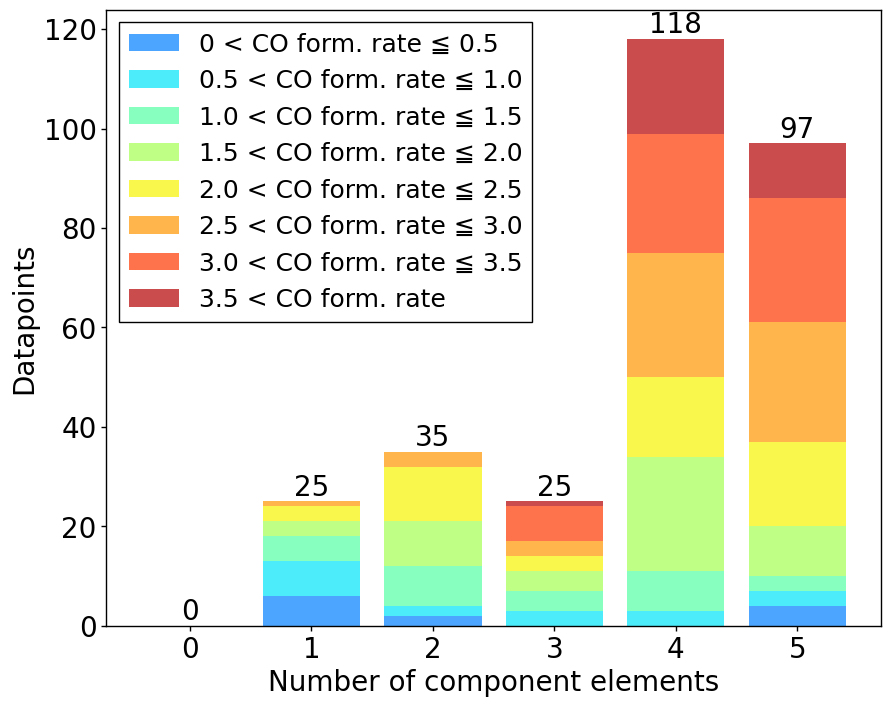

In [4]:
data_count['num_of_component'] = data_count.loc[:, add_desc.index[1:]].sum(axis=1)

comp_num = pd.DataFrame(index=np.arange(0, add_num+1, 1),
                           columns=[
                               '0 < CO form. rate ≦ 0.5',
                               '0.5 < CO form. rate ≦ 1.0',
                               '1.0 < CO form. rate ≦ 1.5',
                               '1.5 < CO form. rate ≦ 2.0',
                               '2.0 < CO form. rate ≦ 2.5',
                               '2.5 < CO form. rate ≦ 3.0',
                               '3.0 < CO form. rate ≦ 3.5',
                               '3.5 < CO form. rate',
                               ]).fillna(0)
for i in range(len(data_count)):
    comp_num.iloc[data_count['num_of_component'][i], data_count['Activity_level'][i]] += 1

fig, ax = plt.subplots(facecolor='white', figsize=(10, 8))
plt.xlabel('Number of component elements', fontsize=20)
plt.ylabel('Datapoints', fontsize=20)
plt.tick_params(labelsize=20)

#cmap_name = 'nipy_spectral'
#cmap_name = 'turbo'
cmap_name = 'jet'
cm = plt.get_cmap(cmap_name)
plt.ylabel('Datapoints', fontsize=20)
for i in range(len(comp_num.columns)):
    z = i/10+0.25
    ax.bar(comp_num.index, comp_num.iloc[:,i], bottom=comp_num.iloc[:, :i].sum(axis=1), align='center', color=cm(z), alpha=0.7)

comp_num['Total datapoints'] = comp_num.sum(axis=1)
for x, y in zip(comp_num.index, comp_num.loc[:, 'Total datapoints']):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=20)

ax.legend(comp_num.columns, fontsize=18)
plt.ylabel('Datapoints', fontsize=20)
plt.savefig(f'{PATH}/Fig_2C_num_of_comp_bar_{cmap_name}_v2.png', dpi=600 ,bbox_inches='tight')

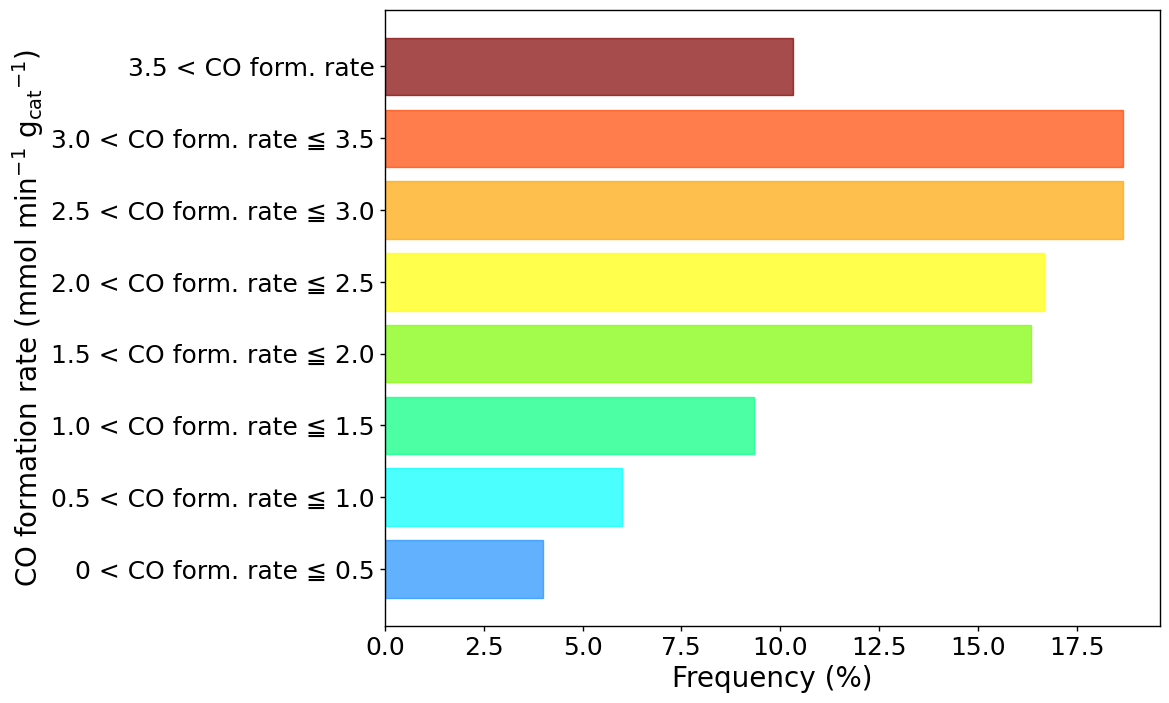

In [5]:
activity_freq = pd.DataFrame(index=[
                               '0 < CO form. rate ≦ 0.5',
                               '0.5 < CO form. rate ≦ 1.0',
                               '1.0 < CO form. rate ≦ 1.5',
                               '1.5 < CO form. rate ≦ 2.0',
                               '2.0 < CO form. rate ≦ 2.5',
                               '2.5 < CO form. rate ≦ 3.0',
                               '3.0 < CO form. rate ≦ 3.5',
                               '3.5 < CO form. rate',
                               ], columns=['Freqency']).fillna(0)
for i in range(len(activity_freq.index)):
    activity_freq.iloc[i] = comp_num.sum(axis=0)[i] / comp_num.sum(axis=0)[-1] * 100

jet_color_list = ['dodgerblue', 'cyan', 'springgreen', 'lawngreen', 'yellow', 'orange', 'orangered', 'maroon']

fig, ax = plt.subplots(facecolor = 'white', figsize = (10, 8))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('Frequency (%)', fontsize=20)
plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=20)
#plt.xticks(rotation=45)
plt.tick_params(labelsize=18)
for i in range(len(activity_freq)):
    plt.barh(activity_freq.index[i], activity_freq.loc[activity_freq.index[i], 'Freqency'], color=jet_color_list[i], alpha=0.7, edgecolor=jet_color_list[i], align='center')

plt.savefig(f'{PATH}/Fig_S4C_activity_freq_barh.png', dpi=600 ,bbox_inches='tight')

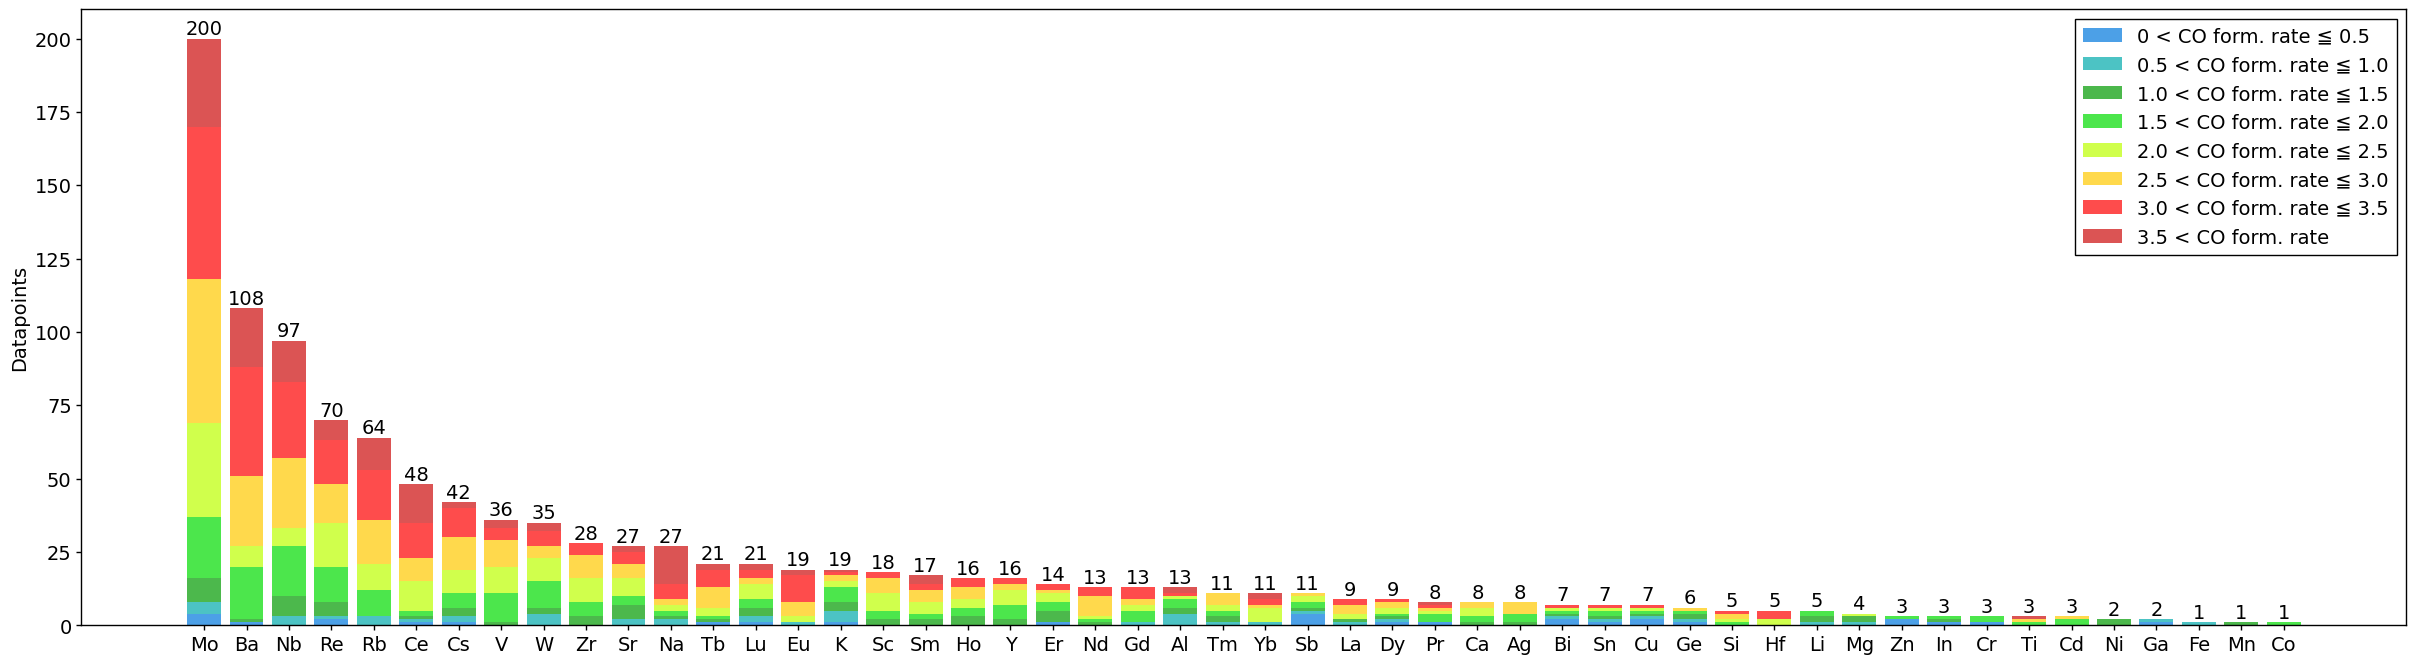

In [6]:
elem_num = pd.DataFrame(index=add_desc.index, columns=['Num_elem',0, 1, 2, 3, 4, 5, 6, 7]).fillna(0)
elem_index = elem_num.index
elem_index_num = elem_num.loc[:, 'Num_elem']


for i in range(len(data)):
    for j in range(pgm_num):
        if data_mol.loc[i, f'PGM{j+1}_μmol'] > 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'PGM{j+1}']] += 1
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'PGM{j+1}']] += 1
        elif data_mol.loc[i, f'PGM{j+1}_μmol'] == 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'PGM{j+1}']] += 0
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'PGM{j+1}']] += 0
    for j in range(add_num):
        if data_mol.loc[i, f'Ad{j+1}_μmol'] > 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'Ad{j+1}']] += 1
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'Ad{j+1}']] += 1
        elif data_mol.loc[i, f'Ad{j+1}_μmol'] == 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'Ad{j+1}']] += 0
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'Ad{j+1}']] += 0

elem_num = elem_num[elem_num['Num_elem'] != 0].sort_values('Num_elem', ascending=False)
elem_sum = elem_num.loc[:, 'Num_elem']
elem_num = elem_num.drop(['Num_elem'], axis=1)
elem_num = elem_num.rename(columns={
    0: '0 < CO form. rate ≦ 0.5',
    1: '0.5 < CO form. rate ≦ 1.0',
    2: '1.0 < CO form. rate ≦ 1.5',
    3: '1.5 < CO form. rate ≦ 2.0',
    4: '2.0 < CO form. rate ≦ 2.5',
    5: '2.5 < CO form. rate ≦ 3.0',
    6: '3.0 < CO form. rate ≦ 3.5',
    7: '3.5 < CO form. rate'
    }).T

fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 8))

cmap_name = 'nipy_spectral'
cm = plt.get_cmap(cmap_name)

plt.ylabel('Datapoints', fontsize=14)
for i in range(len(elem_num)):
    z = i/10+0.25
    ax.bar(elem_num.columns, elem_num.iloc[i], bottom=elem_num.iloc[:i].sum(), align='center', color=cm(z), alpha=0.7)

for x, y in zip(elem_index, elem_index_num):
    if y != 0:
        plt.text(x, y, y, ha='center', va='bottom', fontsize=14)

ax.legend(elem_num.index, fontsize=14)
plt.savefig(f'{PATH}/Fig_2A_elements_bar_{cmap_name}.png', dpi=600 ,bbox_inches='tight')

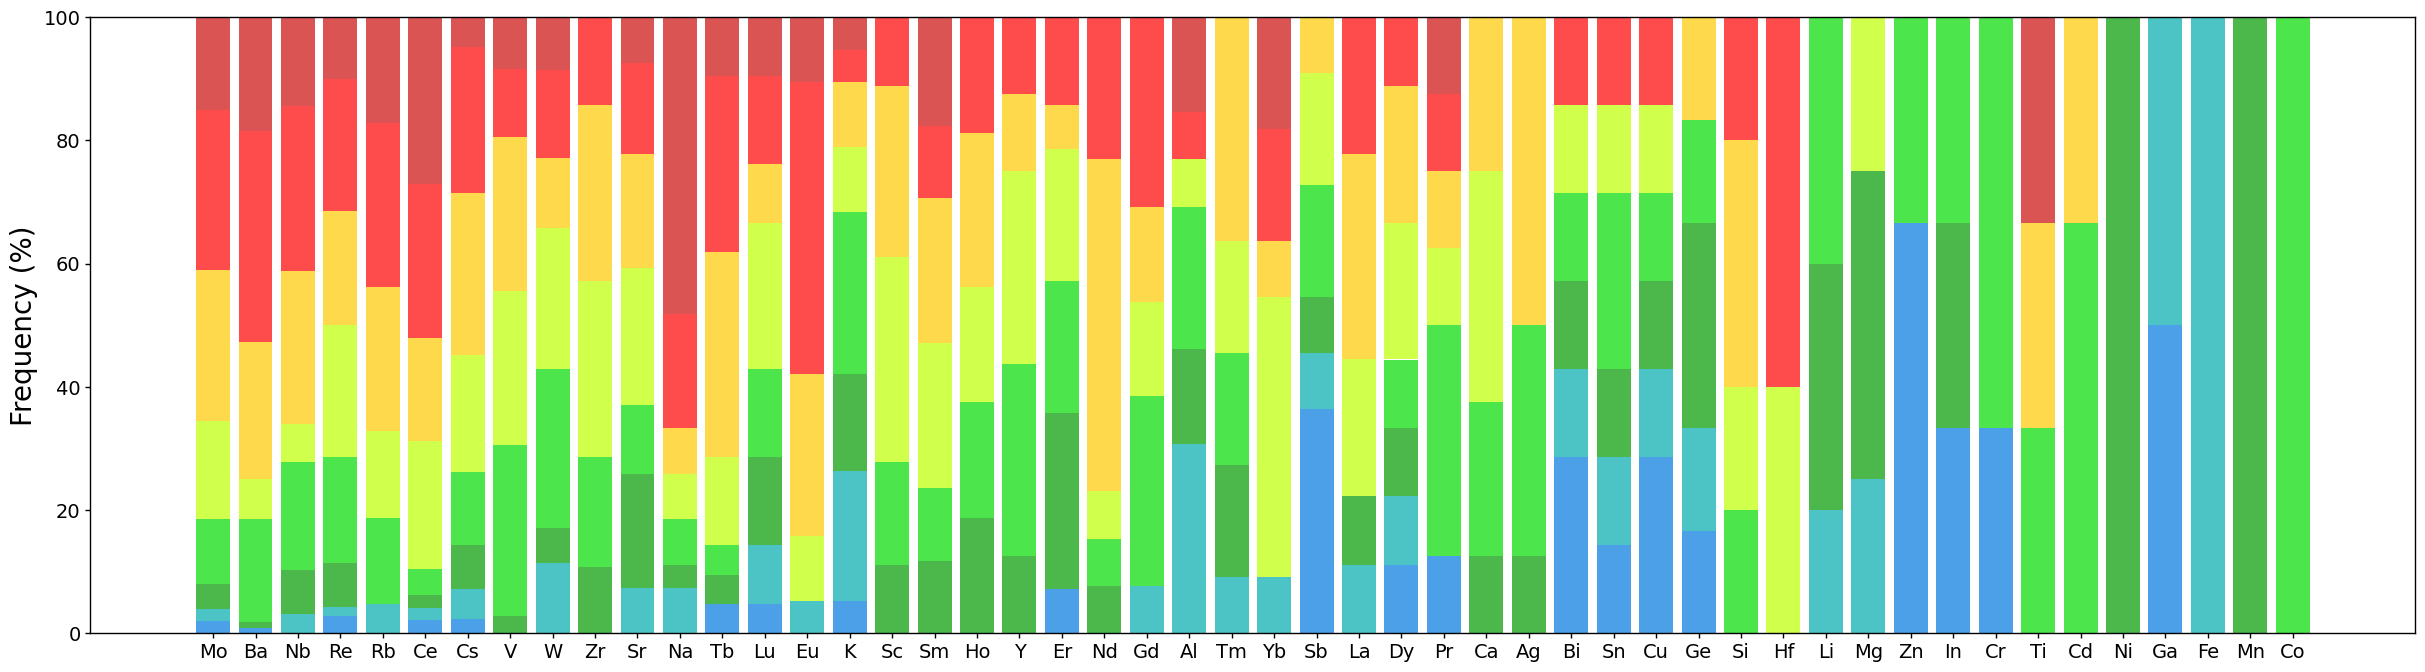

In [7]:
elem_num_band = elem_num.copy()

for i in range(len(elem_num_band.columns)):
    elem_num_band.loc[:, elem_num_band.columns[i]] = elem_num_band.loc[:, elem_num_band.columns[i]]*100/elem_num_band.loc[:, elem_num_band.columns[i]].sum()

fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 8))

cmap_name = 'nipy_spectral'
cm = plt.get_cmap(cmap_name)
plt.ylabel('Frequency (%)', fontsize=20)
#plt.ylabel('(%)', rotation=0, fontsize=14, loc='top')
for i in range(len(elem_num)):
    z = i/10+0.25
    ax.bar(elem_num_band.columns, elem_num_band.iloc[i], bottom=elem_num_band.iloc[:i].sum(), align='center', color=cm(z), alpha=0.7)
    
#ax.legend(elem_num.index, fontsize=14)
plt.savefig(f'{PATH}/Fig_2B_elements_band_{cmap_name}.png', dpi=600 ,bbox_inches='tight')

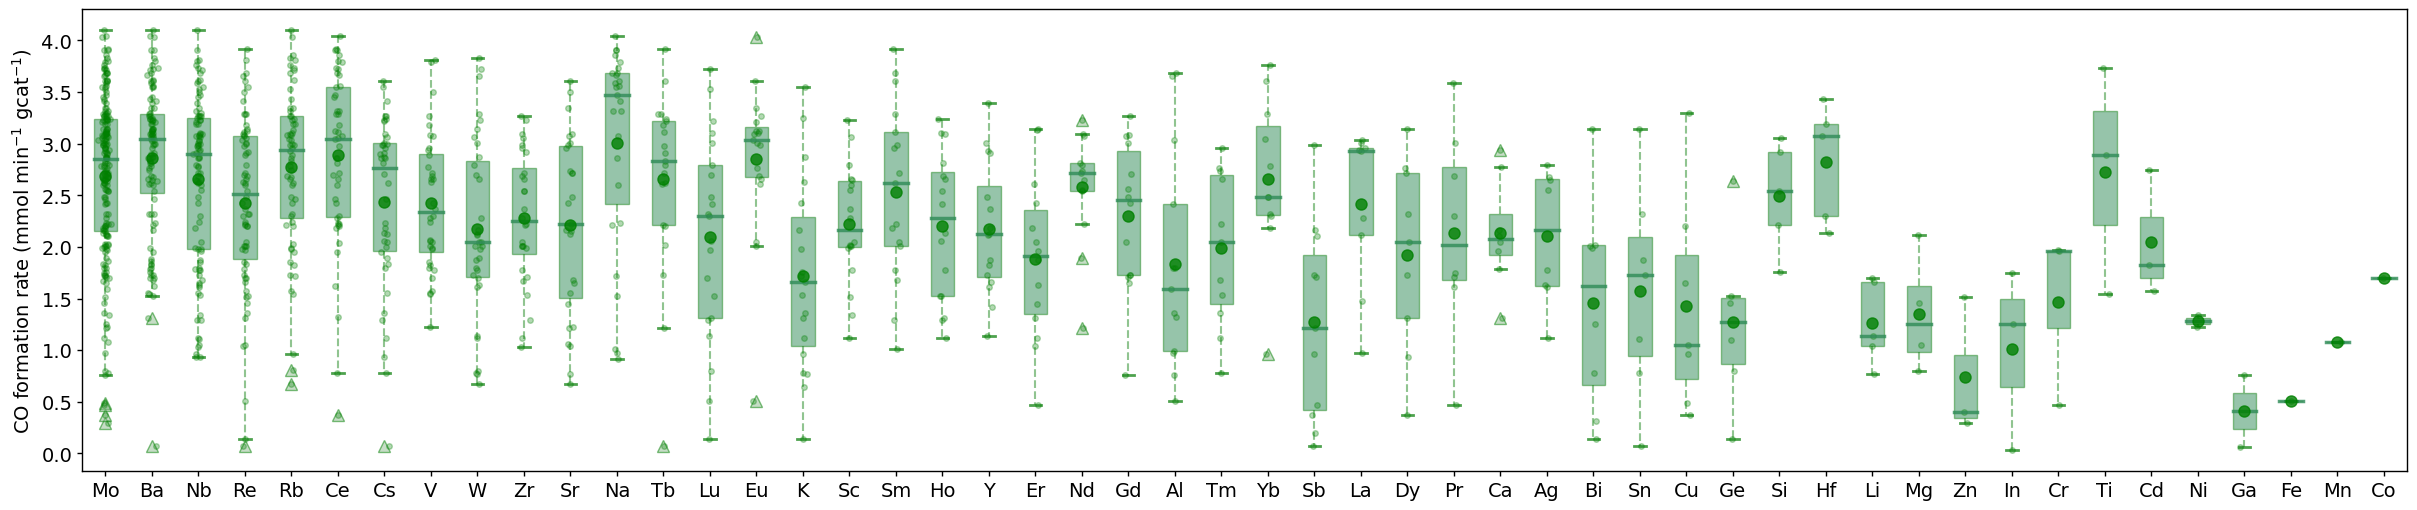

In [9]:
data_wt_plot_all = pd.DataFrame()
for elem in range(len(elem_num.columns)):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_plot_all = pd.concat([data_wt_plot_all, data_wt_ext_plot], axis=1)

fig, ax = plt.subplots(figsize=(30, 6), facecolor='white')

bbox_props = dict(facecolor='seagreen', color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1)
median_props = dict(color='seagreen', alpha=0.8, linestyle='solid', linewidth=2.5)
cap_props = dict(color='forestgreen', alpha=0.8, linestyle='solid', linewidth=2)
line_props = dict(color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1.5)
mean_props = dict(markerfacecolor='green', markeredgecolor='green', marker='o', alpha=0.8, markersize=8)
flier_props = dict(markerfacecolor='darkseagreen', markeredgecolor='green', marker='^', alpha=0.5, markersize=8)

boxplot = ax.boxplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))], labels=elem_num.columns,
                     notch=False, showmeans=True, patch_artist=True,
                     flierprops=flier_props, medianprops=median_props, boxprops=bbox_props, meanprops=mean_props, capprops=cap_props, whiskerprops=line_props)

for i, d in enumerate([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))],):
    y = d
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.plot(x, y, color='green', alpha=0.3, marker='.', linestyle='None', markersize=8)

plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
plt.savefig(f'{PATH}/box_plot.png', dpi=600, bbox_inches='tight')

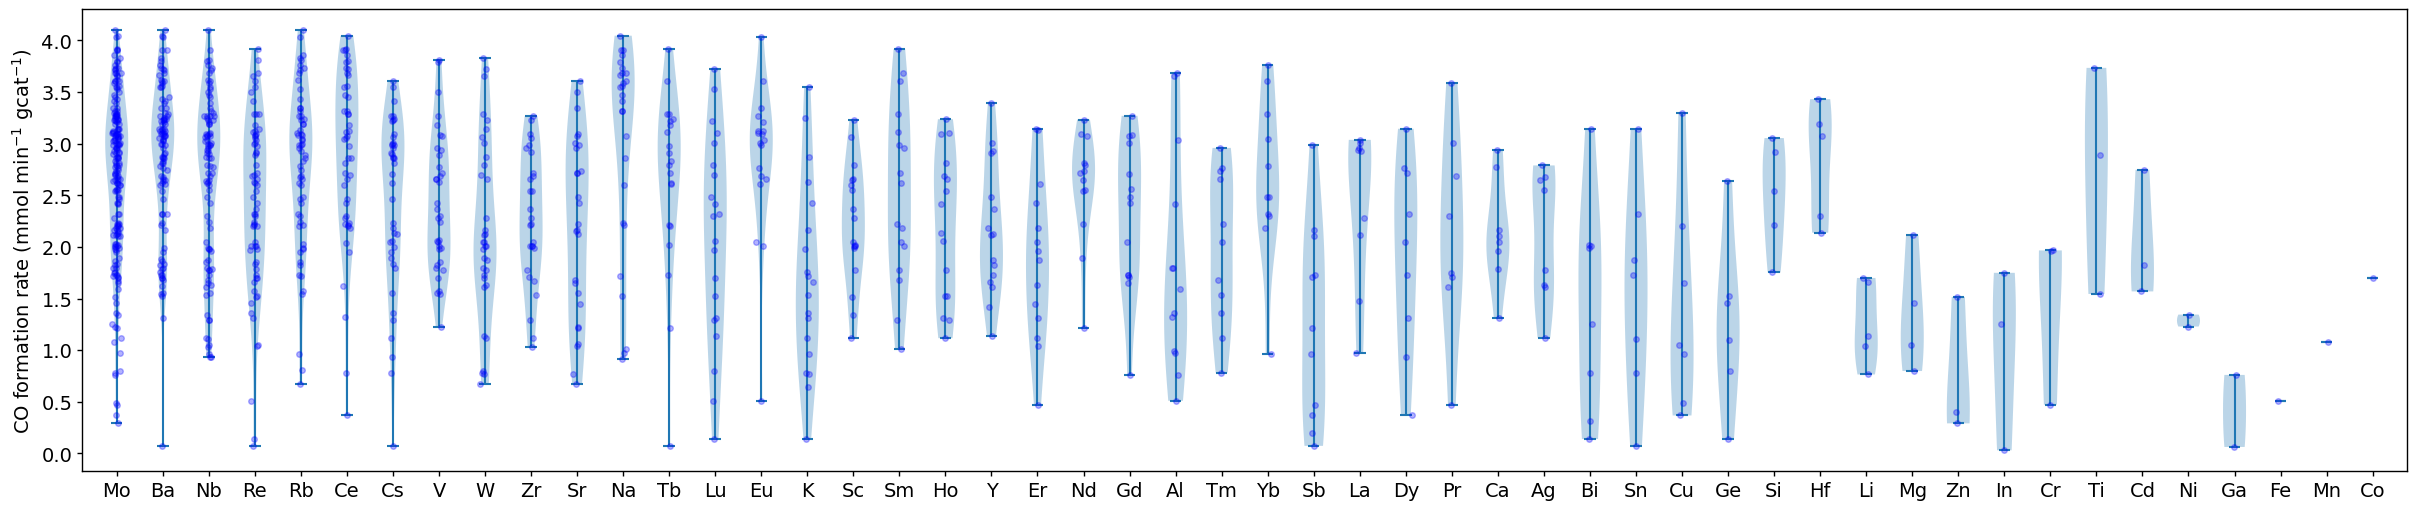

In [10]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 6))
violin = ax.violinplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))])

for i, d in enumerate([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))]):
    y = d
    x = np.random.normal(i + 1, 0.04, len(y))
    ax.plot(x, y, color='blue', alpha=0.3, marker='.', linestyle='None', markersize=8)


set_axis_style(ax, elem_num.columns)

ax.set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
plt.savefig(f'{PATH}/violin_plot.png', dpi=600, bbox_inches='tight')

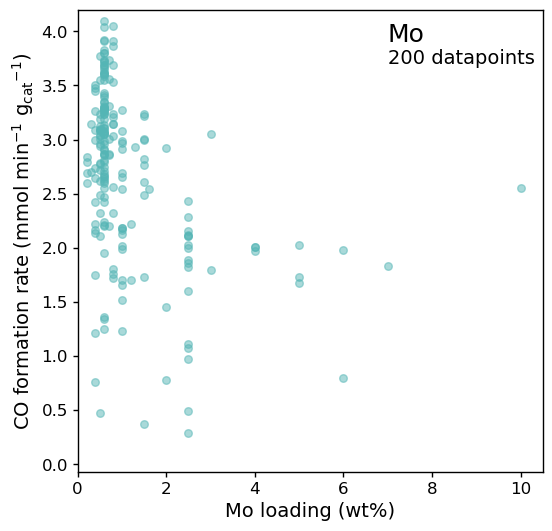

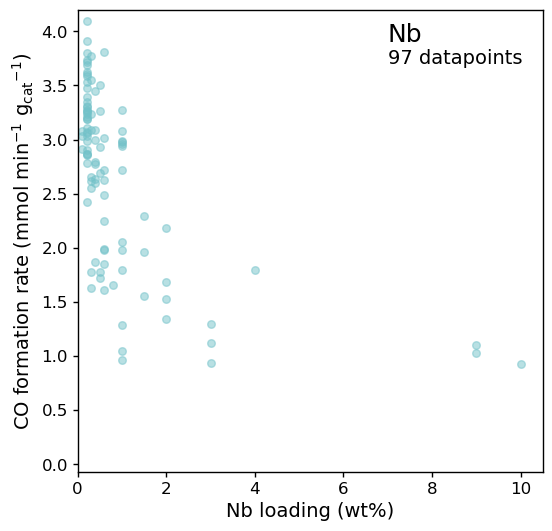

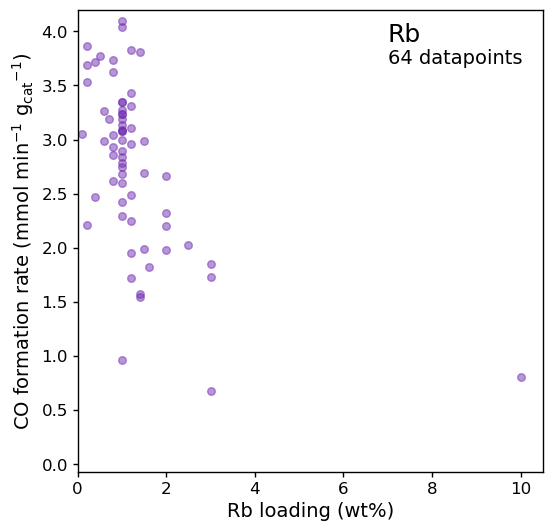

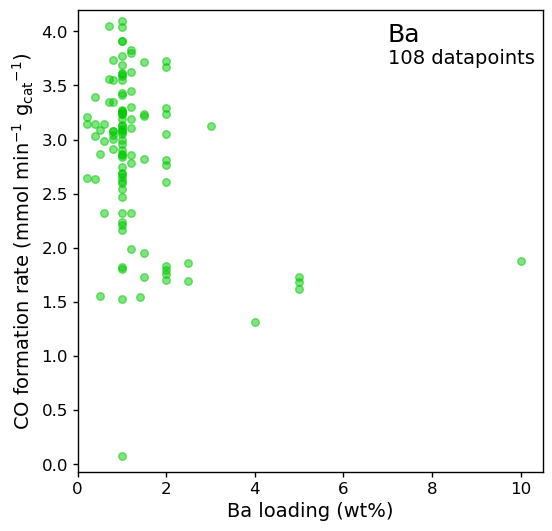

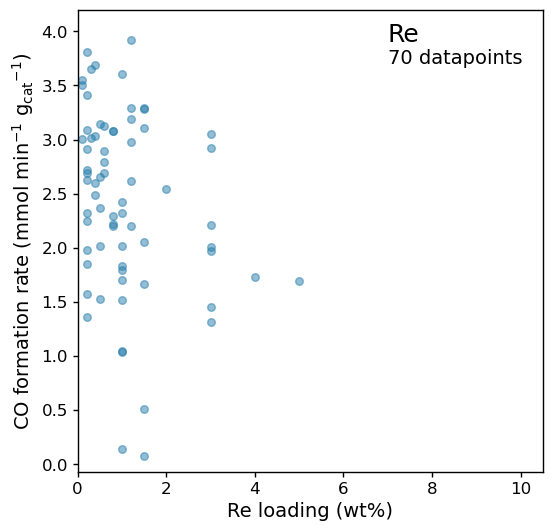

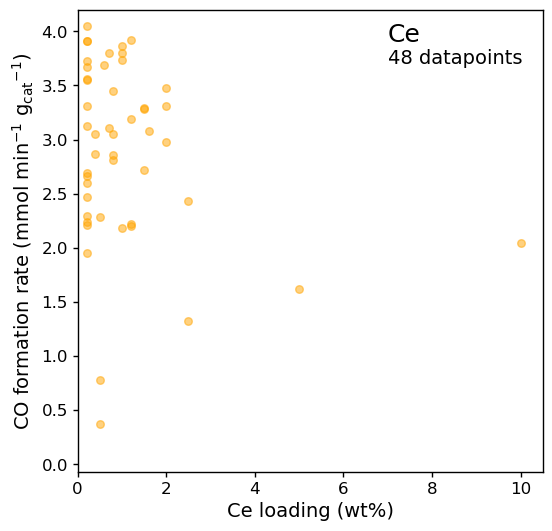

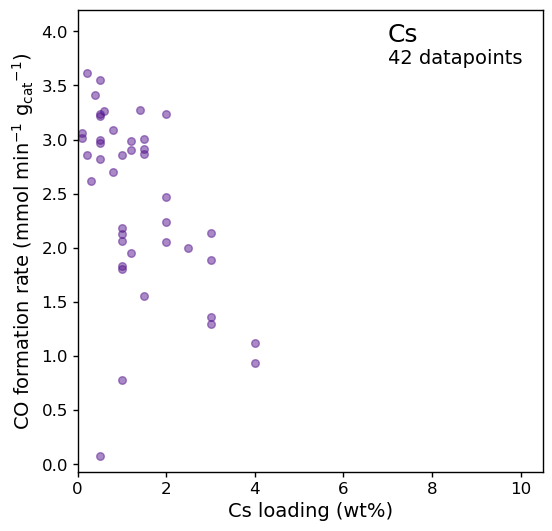

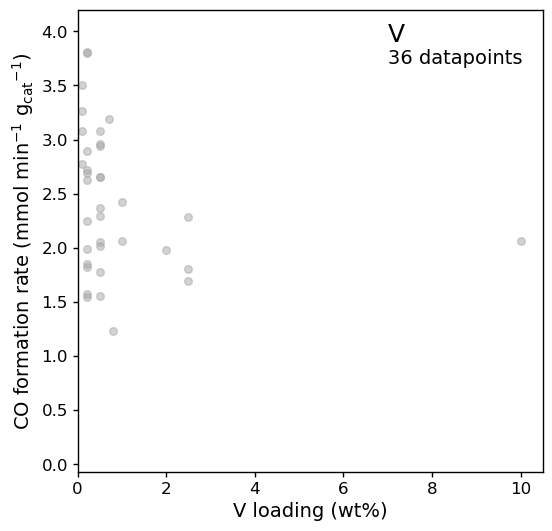

In [15]:
color_dict = {
    'Mo':'#54B5B5',
    'Nb':'#73C2C9',
    'Rb':'#702EB0',
    'Ba':'#00C900',
    'Re':'#267DAB',
    'Ce':'#FFA500',
    'Cs':'#57178F',
    'V':'#A6A6AB',
}

for extract_add in color_dict.keys():
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_ext_plot

    ### Plot ###
    fig, ax = plt.subplots(facecolor = 'white', figsize = (6, 6))
    plt.xlabel(f'{extract_add} loading (wt%)', fontsize=14)
    plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=14)

    plt.tick_params(labelsize=12)
    cm = plt.get_cmap('Blues')
    cm = plt.get_cmap('cool')

    from sklearn import preprocessing
    z = preprocessing.minmax_scale(data_wt_ext_plot[target_name])
    ax.set_xlim(0, 10.5)
    ax.set_ylim(data_wt[target_name].min()-0.1, data_wt[target_name].max()+0.1)
    ax.text(10-3, data_wt[target_name].max()-0.2, extract_add, fontsize=18)
    ax.text(10-3, data_wt[target_name].max()-0.4, f'{len(data_wt_ext_plot)} datapoints', fontsize=14)
    #ax.scatter(data_wt_ext_plot[f'{extract_add}_wt%'], data_wt_ext_plot[target_name], zorder=2, s=30, marker='o', alpha=0.5, color=color_dict[extract_add])
    ax.scatter(data_wt_ext_plot[f'{extract_add}_wt%'], data_wt_ext_plot[target_name], zorder=2, s=30, marker='o', alpha=0.5, color=color_dict[extract_add]) # For Ce
    plt.savefig(f'{PATH}/wt-activity_plot_{extract_add}.png', dpi=600 ,bbox_inches='tight')

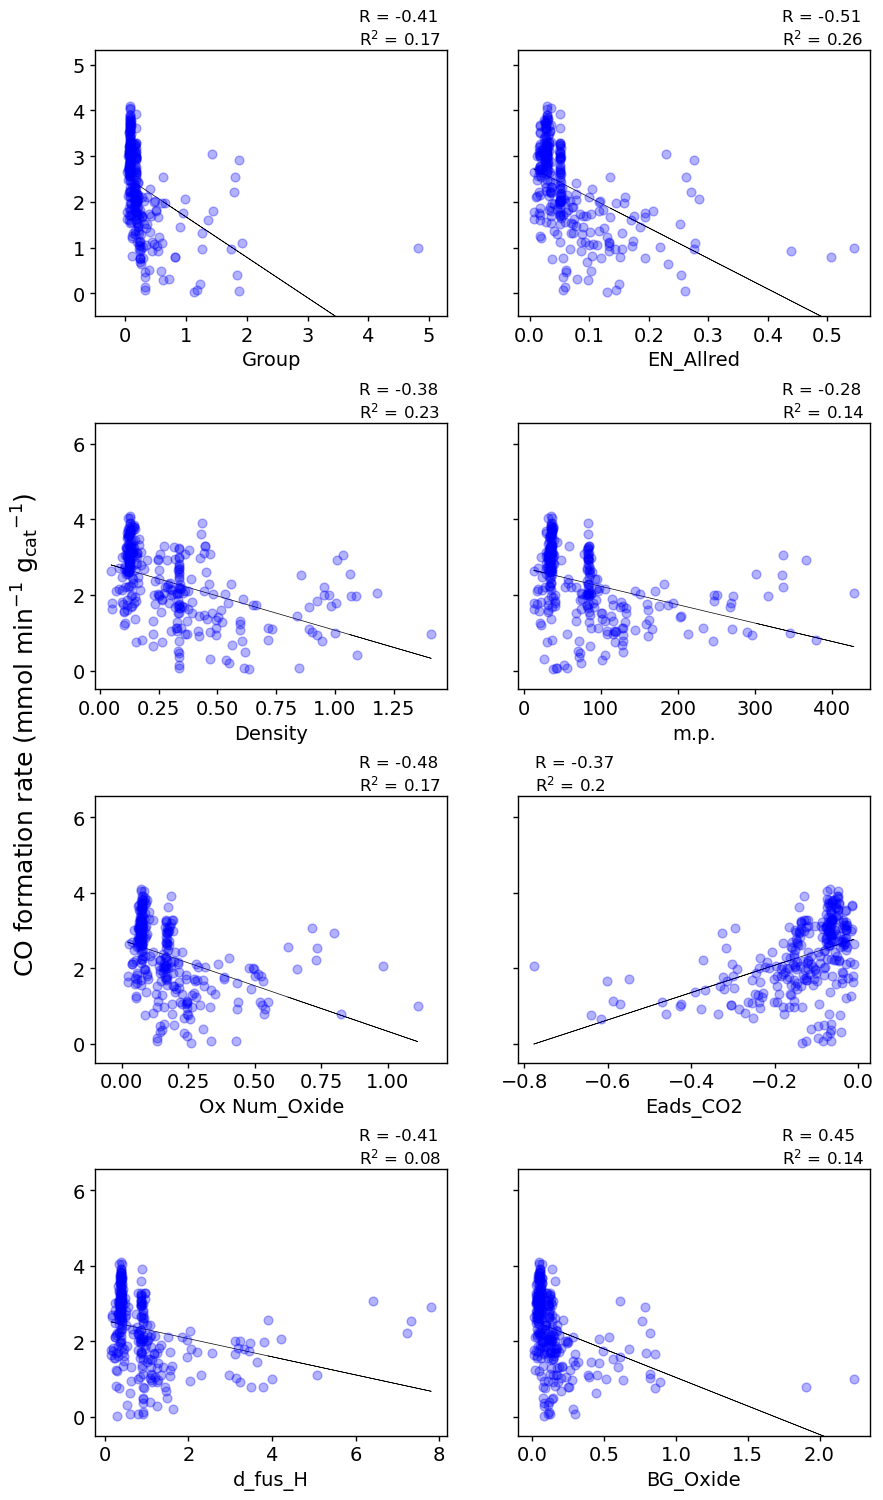

In [16]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

use_add_desc = [ # 'AW' is not used as Descriptor.
    'Group',
    'EN_Allred',
    'Density',
    'm.p.',
    'Ox Num_Oxide',
    'Eads_CO2',
    'd_fus_H',
    'BG_Oxide',
    ]

feat_target = pd.concat([feat, target], axis=1)
feat_target_corr = feat_target.corr()
feat_target_corr['CO formation rate_mmol min-1 gcat-1'] = round(feat_target_corr['CO formation rate_mmol min-1 gcat-1'], 2)
feat_target_corr['R2 value'] = round(feat_target_corr['CO formation rate_mmol min-1 gcat-1']**2, 2)


fig, axes = plt.subplots(4, 2, facecolor='white', sharey='row', figsize = (10, 18), zorder=1)
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.supylabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', x=0.04, fontsize=18)

boxdic = {
    "facecolor" : "white",
    "edgecolor" : "black",
    "linewidth" : 0.5
}

axes[0, 0].scatter(feat[use_add_desc[0]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 0].set_xlabel(use_add_desc[0], fontsize=14)
axes[0, 0].set_xlim(-0.5, feat[use_add_desc[0]].max()*1.1)
axes[0, 0].set_ylim(-0.5, target.max()*1.3)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][0]
model_line = model.fit(np.array(feat[use_add_desc[0]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[0]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[0, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[0,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[0]]).reshape(-1,1))
axes[0, 0].plot(np.array(feat[use_add_desc[0]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[0, 1].scatter(feat[use_add_desc[1]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 1].set_xlabel(use_add_desc[1], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][1]
model_line = model.fit(np.array(feat[use_add_desc[1]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[1]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[0, 1].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[0,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[1]]).reshape(-1,1))
axes[0, 1].plot(np.array(feat[use_add_desc[1]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 0].set_ylim(-0.5, target.max()*1.6)
axes[1, 0].scatter(feat[use_add_desc[2]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[1, 0].set_xlabel(use_add_desc[2], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][2]
model_line = model.fit(np.array(feat[use_add_desc[2]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[2]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[1, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[1,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[2]]).reshape(-1,1))
axes[1, 0].plot(np.array(feat[use_add_desc[2]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 1].scatter(feat[use_add_desc[3]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[1, 1].set_xlabel(use_add_desc[3], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][3]
model_line = model.fit(np.array(feat[use_add_desc[3]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[3]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[1, 1].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[1,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[3]]).reshape(-1,1))
axes[1, 1].plot(np.array(feat[use_add_desc[3]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[2, 0].scatter(feat[use_add_desc[4]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[2, 0].set_xlabel(use_add_desc[4], fontsize=14)
axes[2, 0].set_xlim(-0.1, feat[use_add_desc[4]].max()*1.1)
axes[2, 0].set_ylim(-0.5, target.max()*1.6)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][4]
model_line = model.fit(np.array(feat[use_add_desc[4]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[4]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[2, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[2,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[4]]).reshape(-1,1))
axes[2, 0].plot(np.array(feat[use_add_desc[4]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[2, 1].scatter(feat[use_add_desc[5]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[2, 1].set_xlabel(use_add_desc[5], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][5]
model_line = model.fit(np.array(feat[use_add_desc[5]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[5]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[2, 1].text(0.05, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[2,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[5]]).reshape(-1,1))
axes[2, 1].plot(np.array(feat[use_add_desc[5]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[3, 0].set_ylim(-0.5, target.max()*1.6)
axes[3, 0].scatter(feat[use_add_desc[6]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[3, 0].set_xlabel(use_add_desc[6], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][6]
model_line = model.fit(np.array(feat[use_add_desc[6]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[6]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[3, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[3,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[6]]).reshape(-1,1))
axes[3, 0].plot(np.array(feat[use_add_desc[6]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[3, 1].scatter(feat[use_add_desc[7]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[3, 1].set_xlabel(use_add_desc[7], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][7]
model_line = model.fit(np.array(feat[use_add_desc[7]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[7]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[3, 1].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[3,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[7]]).reshape(-1,1))
axes[3, 1].plot(np.array(feat[use_add_desc[7]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

plt.savefig(f'{PATH}/feat_sum_vs_target_v5.png', dpi=600, bbox_inches='tight')

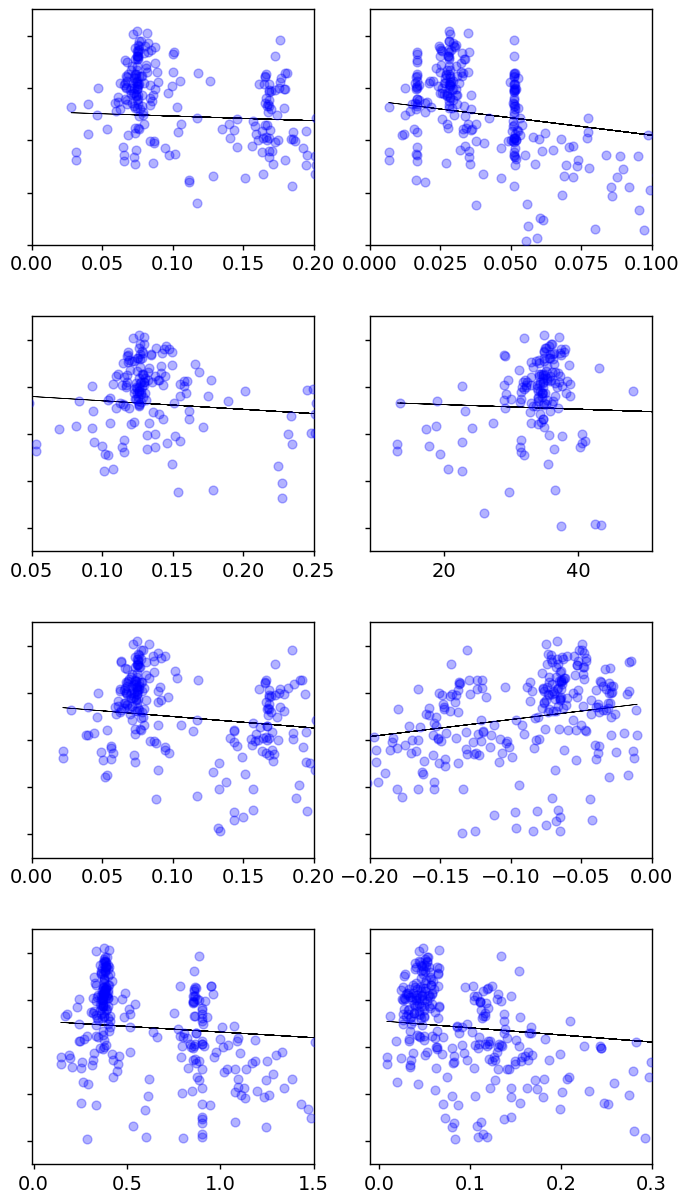

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

use_add_desc = [ # 'AW' is not used as Descriptor.
    'Group',
    'EN_Allred',
    'Density',
    'm.p.',
    'Ox Num_Oxide',
    'Eads_CO2',
    'd_fus_H',
    'BG_Oxide',
    ]

feat_target = pd.concat([feat, target], axis=1)
feat_target_corr = feat_target.corr()
feat_target_corr['CO formation rate_mmol min-1 gcat-1'] = round(feat_target_corr['CO formation rate_mmol min-1 gcat-1'], 2)
feat_target_corr['R2 value'] = round(feat_target_corr['CO formation rate_mmol min-1 gcat-1']**2, 2)


fig, axes = plt.subplots(4, 2, facecolor='white', sharey='row', figsize = (8, 15), zorder=1)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
#fig.supylabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', x=0.04, fontsize=18)

boxdic = {
    "facecolor" : "white",
    "edgecolor" : "black",
    "linewidth" : 0.5
}

axes[0, 0].scatter(feat[use_add_desc[0]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 0].yaxis.set_ticklabels([])
#axes[0, 0].set_xlabel(use_add_desc[0], fontsize=14)
axes[0, 0].set_xlim(0, 0.2)
axes[0, 0].set_ylim(0, target.max()*1.1)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][0]
model_line = model.fit(np.array(feat[use_add_desc[0]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[0]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[0, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[0,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[0]]).reshape(-1,1))
axes[0, 0].plot(np.array(feat[use_add_desc[0]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[0, 1].set_xlim(0, 0.1)
axes[0, 1].scatter(feat[use_add_desc[1]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[0, 1].set_xlabel(use_add_desc[1], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][1]
model_line = model.fit(np.array(feat[use_add_desc[1]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[1]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[0, 1].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[0,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[1]]).reshape(-1,1))
axes[0, 1].plot(np.array(feat[use_add_desc[1]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 0].set_xlim(0.05, 0.25)
axes[1, 0].yaxis.set_ticklabels([])
axes[1, 0].set_ylim(-0.5, target.max()*1.1)
axes[1, 0].scatter(feat[use_add_desc[2]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[1, 0].set_xlabel(use_add_desc[2], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][2]
model_line = model.fit(np.array(feat[use_add_desc[2]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[2]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[1, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[1,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[2]]).reshape(-1,1))
axes[1, 0].plot(np.array(feat[use_add_desc[2]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 1].set_xlim(9, 51)
axes[1, 1].scatter(feat[use_add_desc[3]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[1, 1].set_xlabel(use_add_desc[3], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][3]
model_line = model.fit(np.array(feat[use_add_desc[3]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[3]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[1, 1].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[1,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[3]]).reshape(-1,1))
axes[1, 1].plot(np.array(feat[use_add_desc[3]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[2, 0].set_xlim(0, 0.2)
axes[2, 0].yaxis.set_ticklabels([])
axes[2, 0].scatter(feat[use_add_desc[4]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[2, 0].set_xlabel(use_add_desc[4], fontsize=14)
axes[2, 0].set_ylim(-0.5, target.max()*1.1)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][4]
model_line = model.fit(np.array(feat[use_add_desc[4]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[4]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[2, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[2,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[4]]).reshape(-1,1))
axes[2, 0].plot(np.array(feat[use_add_desc[4]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[2, 1].set_xlim(-0.2, 0)
axes[2, 1].scatter(feat[use_add_desc[5]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[2, 1].set_xlabel(use_add_desc[5], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][5]
model_line = model.fit(np.array(feat[use_add_desc[5]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[5]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[2, 1].text(0.05, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[2,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[5]]).reshape(-1,1))
axes[2, 1].plot(np.array(feat[use_add_desc[5]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[3, 0].set_xlim(-0.01, 1.5)
axes[3, 0].yaxis.set_ticklabels([])
axes[3, 0].set_ylim(-0.5, target.max()*1.1)
axes[3, 0].scatter(feat[use_add_desc[6]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[3, 0].set_xlabel(use_add_desc[6], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][6]
model_line = model.fit(np.array(feat[use_add_desc[6]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[6]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[3, 0].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[3,0].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[6]]).reshape(-1,1))
axes[3, 0].plot(np.array(feat[use_add_desc[6]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[3, 1].set_xlim(-0.01, 0.3)
axes[3, 1].scatter(feat[use_add_desc[7]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
#axes[3, 1].set_xlabel(use_add_desc[7], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][7]
model_line = model.fit(np.array(feat[use_add_desc[7]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[7]]).reshape(-1,1), np.array(target).reshape(-1,1))
#axes[3, 1].text(0.75, 1.02, f'R = {corr}\n$R^{2}$ = ' + str(round(r2_line, 2)), horizontalalignment='left', transform=axes[3,1].transAxes, fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[7]]).reshape(-1,1))
axes[3, 1].plot(np.array(feat[use_add_desc[7]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

plt.savefig(f'{PATH}/feat_sum_vs_target_v5_x.png', dpi=1200, bbox_inches='tight')

In [18]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # 最初の軸を一番上にする
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: x[0], y[0]を2倍にする
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # Axes patchを(x,y) = (0.5,0.5)にし、半径を0.5にする
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon(
                    (0.5, 0.5), num_vars,
                    radius=.5, edgecolor="k"
                    )
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self,
                    spine_type='circle',
                    path=Path.unit_regular_polygon(num_vars)
                    )
                # unit_regular_polygon: 中心(0,0)、半径1の多角形を生成
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                #set_transform:任意の倍率に縮小拡大,任意の座標に中心を移動
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def cat_desc(d, ax, color='r'):
    #labels = list(desc.columns)
    #labels = ['Group', 'electro\nnegativity     ', 'm. p.', 'delta\n fus H ', 'density']
    labels = ['Group', 'EN_Allred', 'm.p.', 'd_fus_H', 'Density', 'BG_Oxide', 'Ox Num\nOxide', 'Eads_CO2']

    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.2)
    #ax.text(x=0, y=d.max()*1.8, s=cat, ha='center', va='top', size=12)
    ax.text(x=0, y=2.3, s=cat, ha='center', va='top', size=12)
    ax.tick_params(pad=13.0)
    #ax.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], labels=[])
    #ax.set_rgrids(np.arange(0, d.max(), d.max()/7), labels=[])
    ax.set_rlim([d.min(), d.max()])
    #ax.set_rlim([0, 1.2])
    ax.set_varlabels(labels)


20220318 rwgs_250 all data
pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


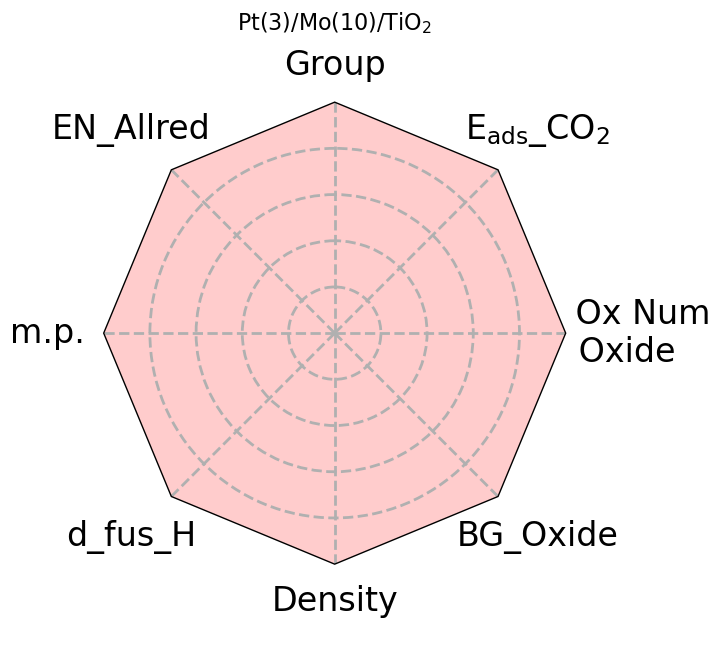

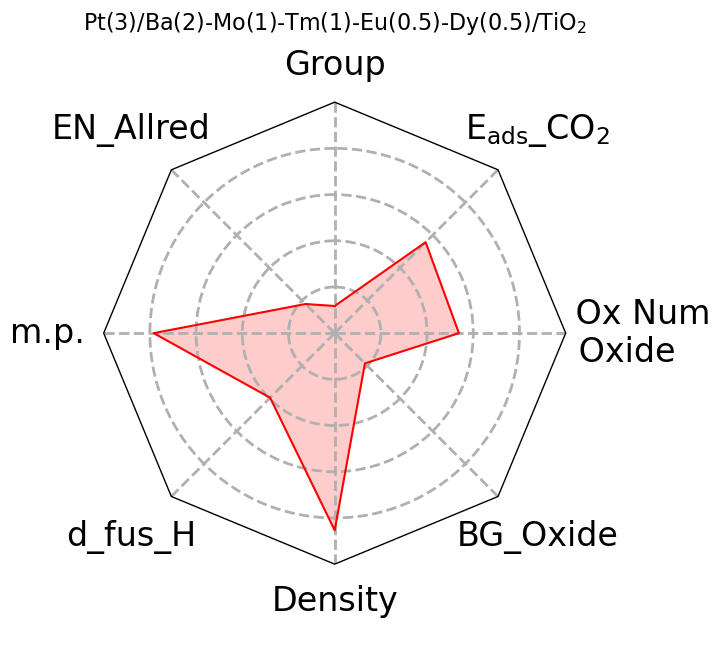

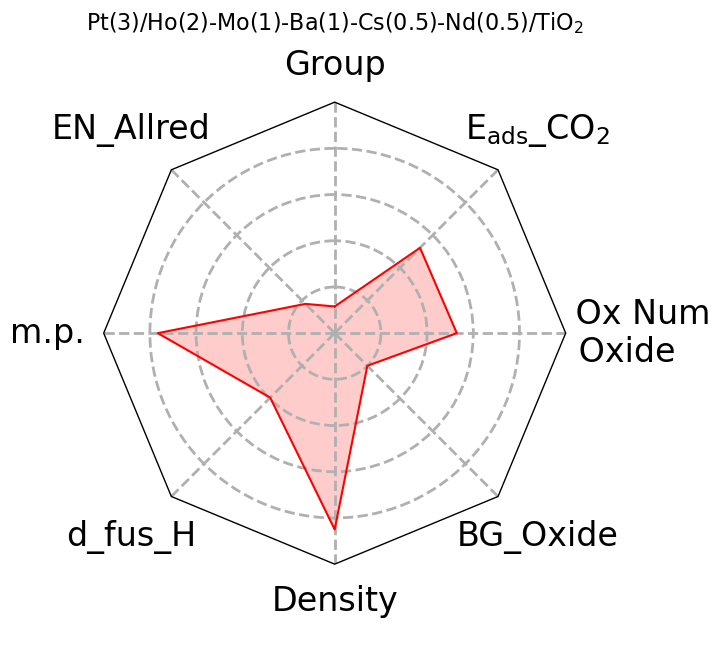

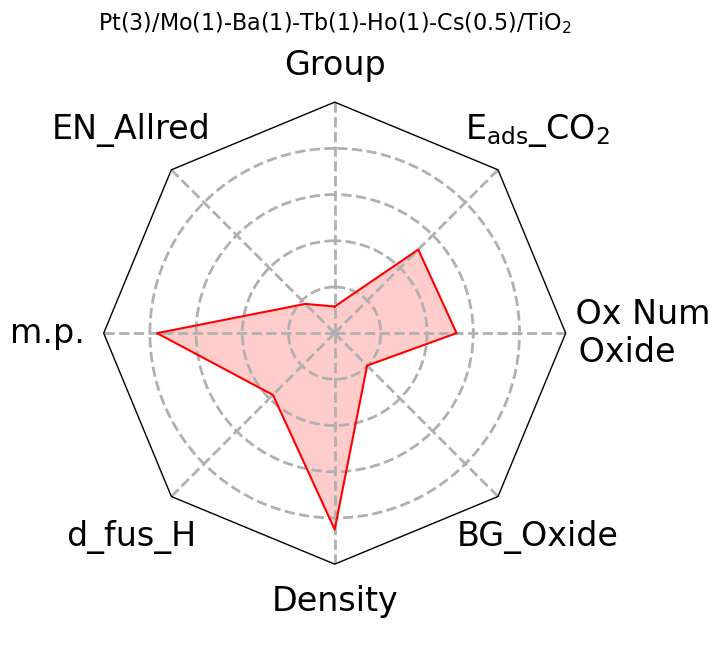

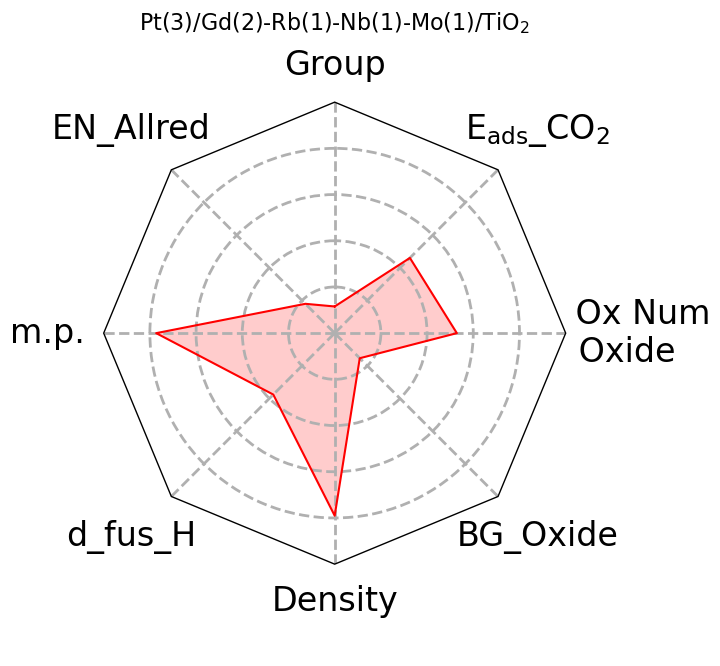

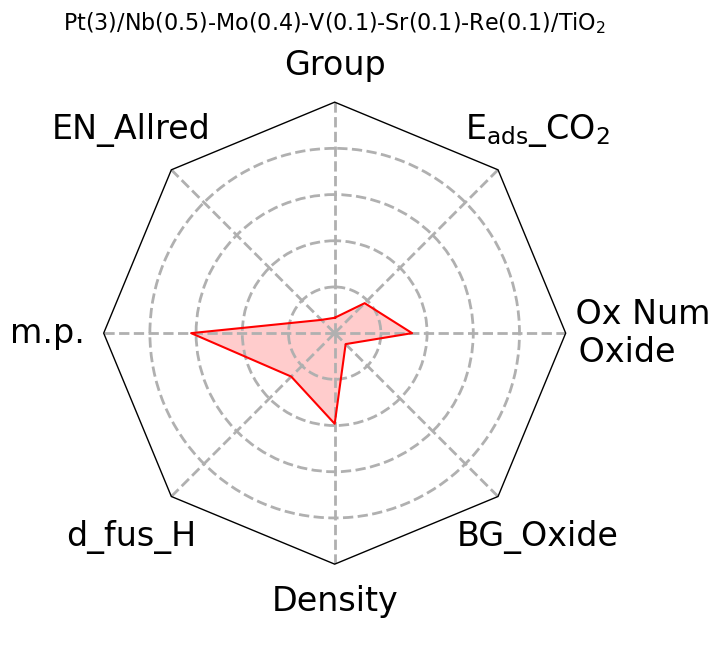

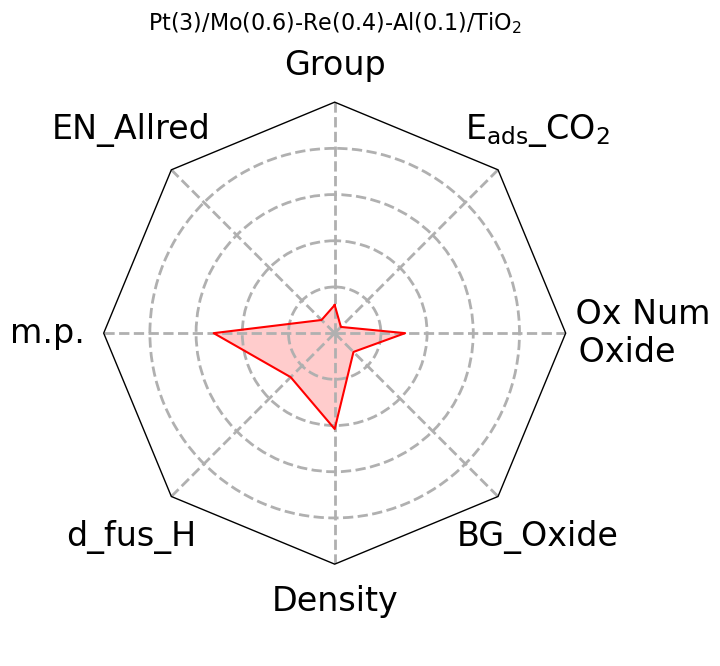

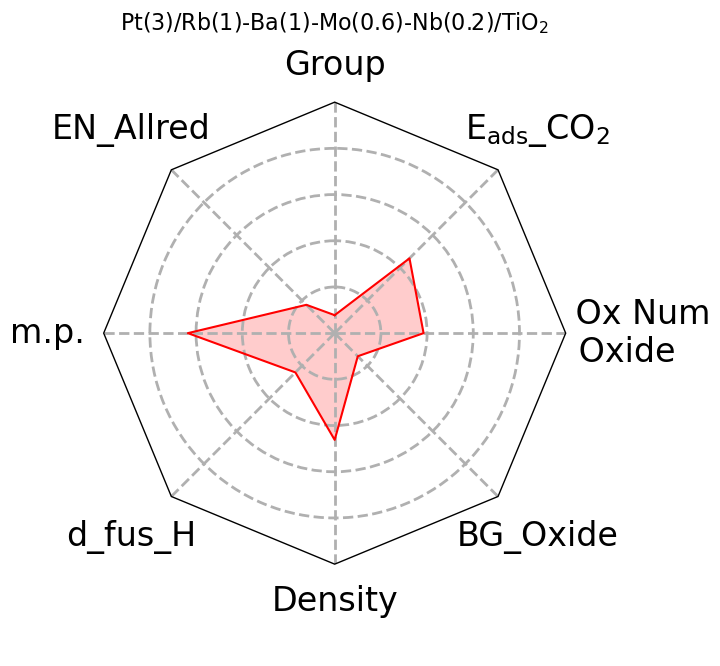

In [20]:
def cat_desc(d, ax, color='r'):
    #labels = list(desc.columns)
    #labels = ['Group', 'electro\nnegativity     ', 'm. p.', 'delta\n fus H ', 'density']
    labels = ['\nGroup', 'EN_Allred', 'm.p.', 'd_fus_H', 'Density\n', 'BG_Oxide', '    Ox Num\n Oxide', '$E_{ads}$_$CO_{2}$']

    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.2)
    ax.text(x=0, y=0.35, s=cat, ha='center', va='top', size=16)
    #ax.text(x=0, y=2.3, s=cat, ha='center', va='top', size=12)
    ax.tick_params(pad=30.0, labelsize=24)
    ax.set_rgrids([0, 0.05, 0.10, 0.15, 0.20], labels=[])
    #ax.set_rlim([d.min(), d.max()])
    ax.set_rlim([0, 0.25])
    ax.set_varlabels(labels)


folder = 'redar_chart'
path = f'{PATH}/' + folder + '/'
os.makedirs(path, exist_ok = True)

condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
target_name = condition['target_name']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
max_target_out, max_target = extract_max_min_target_cat(condition, converted)
add_desc = converted['add_desc']

feat = converted['feat']
feat['Eads_CO2'] = feat['Eads_CO2'].abs()

for i in range(len(feat)):
	feat.iloc[i] = feat.iloc[i] / feat.iloc[0]

feat_norm = (feat - feat.min())/(feat.max() - feat.min())
feat_norm.iloc[0] = feat.iloc[0]
feat_norm = pd.concat([feat_norm, Table_S4['Catalyst']], axis=1)

theta = radar_factory(len(add_desc.columns), frame='polygon')

radar_plot_list = list(max_target_out['No.'].astype(int))

chart_cat_list = [
    'Pt(3)/Mo(10)/TiO$_{2}$',
    'Pt(3)/Ba(2)-Mo(1)-Tm(1)-Eu(0.5)-Dy(0.5)/$TiO_{2}$',
    'Pt(3)/Ho(2)-Mo(1)-Ba(1)-Cs(0.5)-Nd(0.5)/$TiO_{2}$',
    'Pt(3)/Mo(1)-Ba(1)-Tb(1)-Ho(1)-Cs(0.5)/$TiO_{2}$',
    'Pt(3)/Gd(2)-Rb(1)-Nb(1)-Mo(1)/$TiO_{2}$',
    'Pt(3)/Nb(0.5)-Mo(0.4)-V(0.1)-Sr(0.1)-Re(0.1)/$TiO_{2}$',
    'Pt(3)/Mo(0.6)-Re(0.4)-Al(0.1)/$TiO_{2}$',
    'Pt(3)/Rb(1)-Ba(1)-Mo(0.6)-Nb(0.2)/$TiO_{2}$'
    ]

for i in range(0, len(radar_plot_list)):
    
    #print(radar_plot_list[i])
    if len(chart_cat_list) == 0:
        cat = feat_norm['Catalyst'][radar_plot_list[i]-1]
    else:
        cat = chart_cat_list[i]
    d = feat_norm.loc[radar_plot_list[i]-1, add_desc.columns]
    #d_norm = (d - d.min())/(d.max() - d.min())
    #d_norm = d * 1//d.max()
    
    if d.max() < 0.1:
        d = d * 2
    else:
        pass
       
    fig, ax = plt.subplots(figsize=(6,6), facecolor='white', subplot_kw=dict(projection='radar'))
    cat_desc(d, ax, color='r')
    plt.savefig(path + f'No{radar_plot_list[i]}_desc8.png', bbox_inches='tight', dpi=600)